In [19]:
import tensorflow as tf
from tensorflow import keras
from keras import backend
import keras.backend as K
from tensorflow.keras import layers
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.engine.topology import Layer
import numpy as np
import os
import PIL
import PIL.Image
from numpy import asarray
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
K.set_image_data_format('channels_last')

In [20]:
#Defining the class Spatial Pyramid Pooling

class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='channels_last'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_data_format()
        assert self.dim_ordering in {'channels_last', 'channels_first'}, 'dim_ordering must be in {channels_last, channels_first}'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'channels_first':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'channels_last':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        if self.dim_ordering == 'channels_first':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'channels_last':
            num_rows = input_shape[1]
            num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        if self.dim_ordering == 'channels_first':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'channels_last':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                  #range di 3 è 0,1,2
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1, 2))
                        outputs.append(pooled_val)

        if self.dim_ordering == 'channels_first':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'channels_last':
            outputs = K.concatenate(outputs)  #mette lista di liste in lista di valori
            outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

In [ ]:
#Testing SPP with random images

dim_ordering = K.image_data_format()

assert dim_ordering in {'channels_last','channels_first'},'dim_ordering must be in {channels_last,channels_first}'

pooling_regions = [1,2,4]

num_channels = 64
batch_size = 32

if dim_ordering == 'channels_first':
    input_shape = (num_channels, None, None)
elif dim_ordering == 'channels_last':
    input_shape = (None, None, num_channels)

model = Sequential()
model.add(SpatialPyramidPooling(pooling_regions, input_shape=input_shape))
print(model.summary())

model.compile(loss='mse', optimizer='adam')

for img_size in [32,16]:

    if dim_ordering == 'channels_first':
        X = np.random.rand(batch_size, num_channels, img_size, img_size*2)
        row_length = [float(X.shape[2]) / i for i in pooling_regions]
        col_length = [float(X.shape[3]) / i for i in pooling_regions]
    elif dim_ordering == 'channels_last':
        X = np.random.rand(batch_size, img_size, img_size*2, num_channels)
        row_length = [float(X.shape[1]) / i for i in pooling_regions]
        col_length = [float(X.shape[2]) / i for i in pooling_regions]

    Y = model.predict(X)

    for batch_num in range(batch_size):
        idx = 0
        for pool_num, num_pool_regions in enumerate(pooling_regions):
            for jy in range(num_pool_regions):
                for ix in range(num_pool_regions):
                    for cn in range(num_channels):
                        x1 = int(round(ix * col_length[pool_num]))
                        x2 = int(round(ix * col_length[pool_num] + col_length[pool_num]))
                        y1 = int(round(jy * row_length[pool_num]))
                        y2 = int(round(jy * row_length[pool_num] + row_length[pool_num]))

                        if dim_ordering == 'channels_first':
                            m_val = np.max(X[batch_num, cn, y1:y2, x1:x2])
                        elif dim_ordering == 'channels_last':
                            m_val = np.max(X[batch_num, y1:y2, x1:x2, cn])

                        np.testing.assert_almost_equal(
                           m_val, Y[batch_num, idx], decimal=6)
                        idx += 1

print('Spatial pyramid pooling test passed')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_pyramid_pooling (Spa (None, 1344)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None
Spatial pyramid pooling test passed


In [21]:
#Defining data augmentation layer

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(None, 
                                                              None,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [22]:
#The model

num_classes = 5
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

model = Sequential()

model.add(data_augmentation)
# uses theano ordering. Note that we leave the image size as None to allow multiple image sizes
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(None, None,3)))
model.add(normalization_layer)
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(SpatialPyramidPooling([1, 2, 4]))
#model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
#print(model.output_shape)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
rescaling_1 (Rescaling)      (None, None, None, 16)    0         
_________________________________________________________________
activation_5 (Activation)    (None, None, None, 16)    0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
activation_6 (Activation)    (None, None, None, 32)   

In [23]:
#Compile the model

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
#Data downloading

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

3670


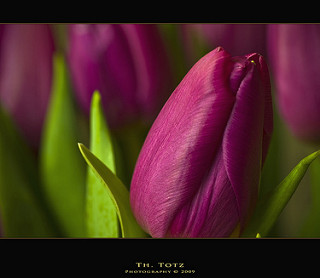

In [ ]:
#Counting and showing an example of image

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [28]:
#Dividing the samples into training and validation datasets

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123, #to avoid overlapping of validation and training set
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

#checking the shape of the labels and the images batches
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
(32, 180, 180, 3)
(32,)


In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(train_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [30]:
#Model fitting

history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/10
92/92 [==============================] - 10s 91ms/step - loss: 0.6051 - accuracy: 0.7660 - val_loss: 0.6456 - val_accuracy: 0.7439
Epoch 2/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5719 - accuracy: 0.7735 - val_loss: 0.6341 - val_accuracy: 0.7507
Epoch 3/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5566 - accuracy: 0.7827 - val_loss: 0.6211 - val_accuracy: 0.7589
Epoch 4/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5422 - accuracy: 0.7970 - val_loss: 0.6081 - val_accuracy: 0.7466
Epoch 5/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5225 - accuracy: 0.7997 - val_loss: 0.6034 - val_accuracy: 0.7616
Epoch 6/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5160 - accuracy: 0.7956 - val_loss: 0.6162 - val_accuracy: 0.7616
Epoch 7/10
92/92 [==============================] - 3s 35ms/step - loss: 0.5126 - accuracy: 0.7990 - val_loss: 0.5994 - val_accuracy: 0.7575
Epoch 8/10
9

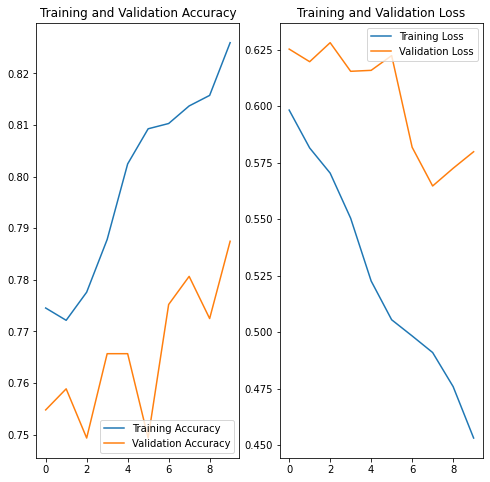

In [ ]:
#plot validation and test accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
#test on a new image
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
score=model(img_array)
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


tf.Tensor([[0.00378617 0.00085872 0.02517858 0.74039364 0.22978283]], shape=(1, 5), dtype=float32)
This image most likely belongs to sunflowers with a 74.04 percent confidence.
